# Parameter and Parameters

[[Fit Statistics]]
    # function evals   = 66
    # data points      = 301
    # variables        = 4
    chi-square         = 11.048
    reduced chi-square = 0.037
    Akaike info crit   = -986.751
    Bayesian info crit = -971.922
[[Variables]]
    amp:     4.96078855 +/- 0.037912 (0.76%) (init= 10)
    decay:   0.02437788 +/- 0.000426 (1.75%) (init= 0.1)
    shift:  -0.10363211 +/- 0.009816 (9.47%) (init= 0)
    omega:   2.00019266 +/- 0.003095 (0.15%) (init= 3)
[[Correlations]] (unreported correlations are <  0.100)
    C(shift, omega)              = -0.785 
    C(amp, decay)                =  0.584 
    C(amp, shift)                = -0.117 


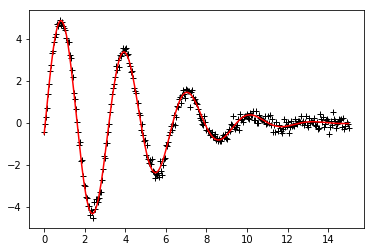

In [36]:
import lmfit
import numpy as np

x = np.linspace(0, 15, 301)
data = (5. * np.sin(2 * x - 0.1) * np.exp(-x*x*0.025) +
        np.random.normal(size=len(x), scale=0.2) )

# OBJECTIVE FUNCTION
def fcn2min(params, x, data):
    """ model decaying sine wave, subtract data"""
    v = params.valuesdict()
    model = v['amp'] * np.sin(x * v['omega'] + v['shift']) * np.exp(-x*x*v['decay'])
    return model - data

params = lmfit.Parameters()
params.add('amp',   value= 10,  min=0)
params.add('decay', value= 0.1)
params.add('shift', value= 0.0, min=-np.pi/2., max=np.pi/2)
params.add('omega', value= 3.0)

# FIT W/ LEAST SQ
minner = lmfit.Minimizer(fcn2min, params, fcn_args=(x, data))
result = minner.minimize()
final = data + result.residual

# ERROR REPORT
lmfit.report_fit(result)

try:
    import pylab
    pylab.plot(x, data, 'k+')
    pylab.plot(x, final, 'r')
    pylab.show()
except:
    pass

# Fits and Analysis
Ex: implementing parameter bounds/checks inside of function

In [37]:
def residual(pars, x, data=None, eps=None):
    par_vals = pars.valuesdict()
    period = par_vals['period']
    shift = par_vals['shift']
    decay = par_vals['decay']

    if abs(shift) > pi/2:
        shift = shift - sign(shift)*pi
    
    # assign min value to period (!=0)
    if abs(period) < 1.e-10:
        period = sign(period)*1.e-10

    model = par_vals['amp'] * sin(shift + x/period) * np.exp(-x*x*decay*decay)

    if data is None:
        return model
    if eps is None:
        return (model - data)
    return (model - data)/eps

### Iteration Callback Function
<b> iter_cb(params, iter, resid, *args, **kws): </b> <br/>
Called at each iteration right after obj function <br/> 
Allows user-supplied code to be run at each iteration - can be used to abort fit

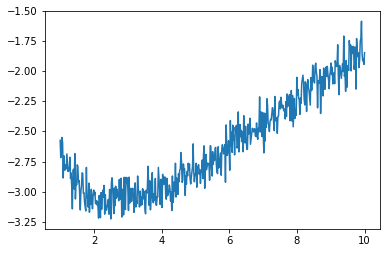

In [38]:
import matplotlib.pyplot as plt

x = np.linspace(1, 10, 500)
np.random.seed(0)
y = 3.0 * np.exp(-x / 2) - 5.0 * np.exp(-(x - 0.1) / 10.) + 0.1 * np.random.randn(len(x))
plt.plot(x, y)
plt.show()

In [39]:
p = lmfit.Parameters()
p.add_many(('a1', 4.), ('a2', 4.), ('t1', 3.), ('t2', 3., True))

def residual(p):
     v = p.valuesdict()
     return v['a1'] * np.exp(-x / v['t1']) + v['a2'] * np.exp(-(x - 0.1) / v['t2']) - y

In [40]:
mi = lmfit.minimize(residual, p, method='powell')
# mi = lmfit.minimize(residual, p, method='Nelder')
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

[[Variables]]
    a1:  -8.57931200 (init= 4)
    a2:   6.10927930 (init= 4)
    t1:   7.20170210 (init= 3)
    t2:   3.40286517 (init= 3)


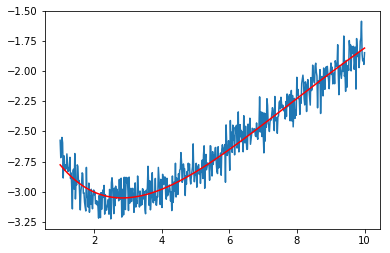

In [41]:
plt.plot(x, y)
plt.plot(x, residual(mi.params) + y, 'r')
plt.show()

### Try Some Uncertainties

In [42]:
# Add some noise
mi.params.add('f', value=1, min=0.001, max=2)

# calculate the uncertainties
def lnprob(p):
    resid = residual(p)
    s = p['f']
    resid *= 1 / s
    resid *= resid
    resid += np.log(2 * np.pi * s**2)
    return -0.5 * np.sum(resid)

mini = lmfit.Minimizer(lnprob, mi.params)
res = mini.emcee(burn=300, steps=600, thin=10, params=mi.params)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


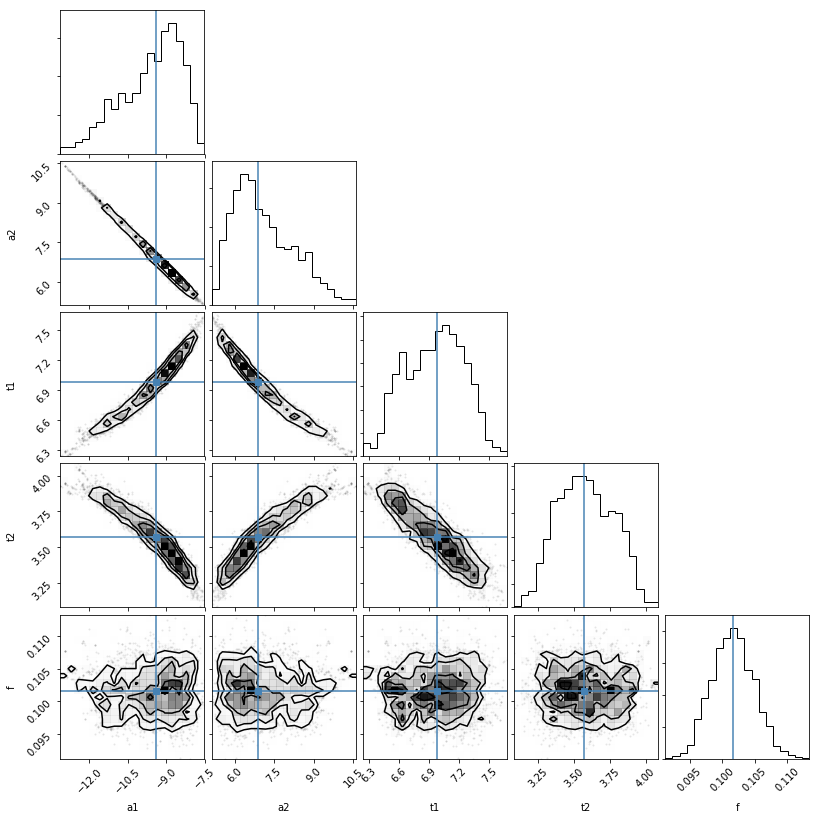

In [43]:
import corner
corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()))

## Generating Fit Reports

In [44]:
from __future__ import print_function
from numpy import random, linspace, pi, exp, sin, sign

p_true = lmfit.Parameters()
p_true.add('amp', value=14.0)
p_true.add('period', value=5.46)
p_true.add('shift', value=0.123)
p_true.add('decay', value=0.032)

def residual(pars, x, data=None):
    vals = pars.valuesdict()
    amp =  vals['amp']
    per =  vals['period']
    shift = vals['shift']
    decay = vals['decay']

    if abs(shift) > pi/2:
        shift = shift - sign(shift)*pi
    model = amp * sin(shift + x/per) * exp(-x*x*decay*decay)
    if data is None:
        return model
    return (model - data)

n = 1001
xmin = 0.
xmax = 250.0

random.seed(0)

noise = random.normal(scale=0.7215, size=n)
x     = linspace(xmin, xmax, n)
data  = residual(p_true, x) + noise

fit_params = lmfit.Parameters()
fit_params.add('amp', value=13.0)
fit_params.add('period', value=2)
fit_params.add('shift', value=0.0)
fit_params.add('decay', value=0.02)

out = lmfit.minimize(residual, fit_params, args=(x,), kws={'data':data})

print(lmfit.fit_report(out))


[[Fit Statistics]]
    # function evals   = 85
    # data points      = 1001
    # variables        = 4
    chi-square         = 498.812
    reduced chi-square = 0.500
    Akaike info crit   = -689.223
    Bayesian info crit = -669.587
[[Variables]]
    amp:      13.9121944 +/- 0.141202 (1.01%) (init= 13)
    period:   5.48507044 +/- 0.026664 (0.49%) (init= 2)
    shift:    0.16203676 +/- 0.014056 (8.67%) (init= 0)
    decay:    0.03264538 +/- 0.000380 (1.16%) (init= 0.02)
[[Correlations]] (unreported correlations are <  0.100)
    C(period, shift)             =  0.797 
    C(amp, decay)                =  0.582 
    C(amp, shift)                = -0.297 
    C(amp, period)               = -0.243 
    C(shift, decay)              = -0.182 
    C(period, decay)             = -0.150 


# Modeling Data and Curve Fitting
<b> You can set default initial values and control other paramater attributes using: </b> <br/>
model.set_param_hint('b', value = 0.3, min=0)

### Scipy Method

In [45]:
from numpy import sqrt, pi, exp, linspace, random
from scipy.optimize import curve_fit

def gaussian(x, amp, cen, wid):
    return amp * exp(-(x-cen)**2 /wid)

# Data
x = linspace(-10, 10, 101)
y = gaussian(x, 2.33, 0.21, 1.51) + random.normal(0, 0.2, len(x))

# Initial Guess
init_vals = [1, 0, 1] #[amp, cen, wid]

# Fit
best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)
print(best_vals)

[ 2.35722319  0.2257918   1.54368098]


### LMFIT Method

In [56]:
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit import  Model
import matplotlib.pyplot as plt

gmod = Model(gaussian)
print(gmod.param_names)
print(gmod.independent_vars)

['amp', 'cen', 'wid']
['x']


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 201
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -inf
    Bayesian info crit = -inf
[[Variables]]
    amp:   200        +/- 0        (0.00%) (init= 100)
    cen:   5          +/- 0        (0.00%) (init= 6.5)
    wid:   1          +/- 0        (0.00%) (init= 2)



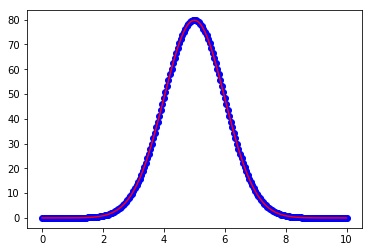

In [70]:
params = gmod.make_params(cen=5, amp=200, wid=1)
x = linspace(0, 10, 201)
y = gmod.eval(params, x=x)

def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))

gmod = Model(gaussian)
result = gmod.fit(y, x=x, amp=100, cen=6.5, wid=2.0)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.best_fit, 'r-')
plt.show()

### Composite models: Adding/Multiplying Models

In [24]:
def gaussian_plus_line(x, amp, cen, wid, slope, intercept):
    gauss = (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))
    line = slope * x + intercept
    return gauss + line

mod = Model(gaussian_plus_line)

### Build complex models from components

[[Model]]
    (Model(jump) <function convolve at 0x000000000D1CBEB8> Model(gaussian))
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 201
    # variables        = 3
    chi-square         = 22.113
    reduced chi-square = 0.112
    Akaike info crit   = -437.632
    Bayesian info crit = -427.722
[[Variables]]
    mid:         5 (fixed)
    sigma:       0.64150204 +/- 0.013290 (2.07%) (init= 1.5)
    center:      4.51795438 +/- 0.009608 (0.21%) (init= 3.5)
    amplitude:   0.62438374 +/- 0.001814 (0.29%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(center, amplitude)         =  0.344 
    C(sigma, amplitude)          =  0.280 



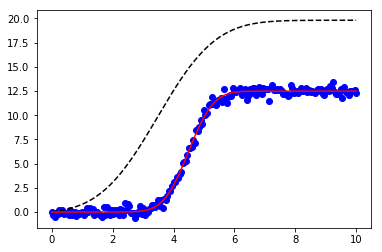

In [25]:
import numpy as np
from lmfit import Model, CompositeModel
from lmfit.lineshapes import step, gaussian

import matplotlib.pyplot as plt

# create data from broadened step
npts = 201
x = np.linspace(0, 10, npts)
y = step(x, amplitude=12.5, center=4.5, sigma=0.88, form='erf')
y = y + np.random.normal(size=npts, scale=0.35)

def jump(x, mid):
    "heaviside step function"
    o = np.zeros(len(x))
    imid = max(np.where(x<=mid)[0])
    o[imid:] = 1.0
    return o

def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]
#
# create Composite Model using the custom convolution operator
mod  = CompositeModel(Model(jump), Model(gaussian), convolve)

pars = mod.make_params(amplitude=1, center=3.5, sigma=1.5, mid=5.0)

# 'mid' and 'center' should be completely correlated, and 'mid' is
# used as an integer index, so a very poor fit variable:
pars['mid'].vary = False

# fit this model to data array y
result =  mod.fit(y, params=pars, x=x)

print(result.fit_report())

plot_components = False

# plot results
plt.plot(x, y,         'bo')
if plot_components:
    # generate components
    comps = result.eval_components(x=x)
    plt.plot(x, 10*comps['jump'], 'k--')
    plt.plot(x, 10*comps['gaussian'], 'r-')
else:
    plt.plot(x, result.init_fit, 'k--')
    plt.plot(x, result.best_fit, 'r-')
plt.show()